# **Machine Learning Project**

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
!wget https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip

--2022-06-25 20:02:27--  https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135033638 (129M) [application/zip]
Saving to: ‘spatial_envelope_256x256_static_8outdoorcategories.zip’

spatial_envelope_25 100%[===================>] 128.78M  10.3MB/s    in 13s     

2022-06-25 20:02:41 (9.74 MB/s) - ‘spatial_envelope_256x256_static_8outdoorcategories.zip’ saved [135033638/135033638]



In [3]:
!unzip spatial_envelope_256x256_static_8outdoorcategories.zip

Archive:  spatial_envelope_256x256_static_8outdoorcategories.zip
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_arnat59.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_art1130.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_art294.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_art487.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea1.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea10.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea14.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea2.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea20.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea24.jpg  
  inflating: spatial_envelope_256x256_static_8outdoorcategories/coast_bea26.jpg  
  inflating: spatial_envelope

In [4]:
!mkdir dataset


In [5]:
cd dataset

/content/dataset


In [6]:
!mkdir coast
!mkdir forest
!mkdir highway
!mkdir insidecity
!mkdir mountain
!mkdir opencountry
!mkdir street
!mkdir building

In [7]:
cd ..

/content


In [8]:
import glob
import shutil
import os

src_dir = "spatial_envelope_256x256_static_8outdoorcategories/"

for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):

    if "building" in jpgfile:
      shutil.copy(jpgfile, "dataset/building/")

    elif "coast" in jpgfile:
      shutil.copy(jpgfile, "dataset/coast/")

    elif "forest" in jpgfile:
      shutil.copy(jpgfile, "dataset/forest/")

    elif "highway" in jpgfile:
      shutil.copy(jpgfile, "dataset/highway/")

    elif "insidecity" in jpgfile:
      shutil.copy(jpgfile, "dataset/insidecity/")
    
    elif "mountain" in jpgfile:
      shutil.copy(jpgfile, "dataset/mountain/")

    elif "opencountry" in jpgfile:
      shutil.copy(jpgfile, "dataset/opencountry/")

    elif "street" in jpgfile:
      shutil.copy(jpgfile, "dataset/street/")

    else:
      print("nothing happend")

In [9]:
data_dir = "dataset/"
batch_size = 64

import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  batch_size=5000)



Found 2688 files belonging to 8 classes.
Using 2420 files for training.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  batch_size=5000)

Found 2688 files belonging to 8 classes.
Using 268 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['building', 'coast', 'forest', 'highway', 'insidecity', 'mountain', 'opencountry', 'street']


In [12]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

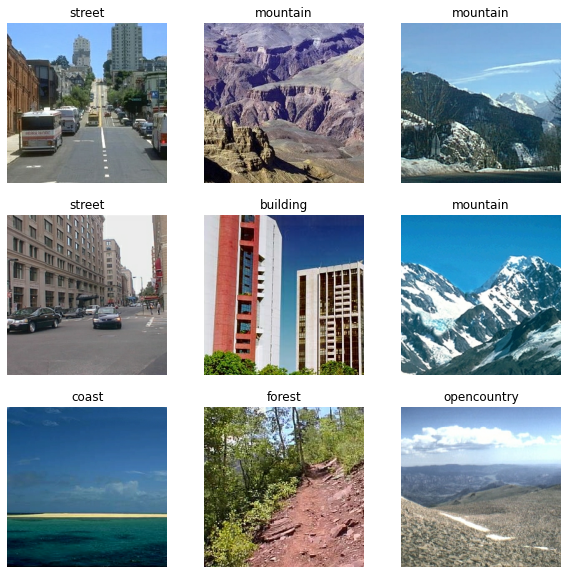

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(2420, 256, 256, 3)
(2420,)


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.078431375 1.0


# **ResNet**

In [17]:
import tensorflow as tf

resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

resnet.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [18]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [19]:
print(images.shape)
print(labels.shape)

(2420, 256, 256, 3)
(2420,)


tf.Tensor(5, shape=(), dtype=int32)


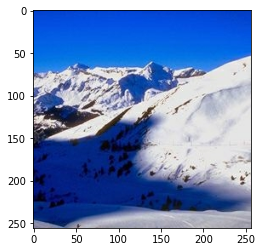

In [20]:
print(labels[1])

plt.imshow(images[1], cmap='gray')

In [21]:
class_names[4]

'insidecity'

In [22]:
generatedFeatures = resnet.predict(images)

In [23]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [24]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [25]:
TRdata[0].shape

(131072,)

In [26]:
len(TRdata)

2420

In [27]:
labels

<tf.Tensor: shape=(2420,), dtype=int32, numpy=array([2, 5, 3, ..., 7, 4, 2], dtype=int32)>

In [ ]:
clf = svm.SVC(kernel = "poly", degree=3, decision_function_shape = "ovo")
clf.fit(TRdata, labels)

SVC(decision_function_shape='ovo', kernel='poly')

In [29]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [30]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]



In [31]:
print(Testimages.shape)
print(Testlabels.shape)

(268, 256, 256, 3)
(268,)


In [32]:
TestgeneratedFeatures = resnet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

**train**

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       284
           1       1.00      0.99      0.99       287
           2       0.90      1.00      0.95       267
           3       1.00      1.00      1.00       209
           4       1.00      0.99      0.99       239
           5       0.99      0.96      0.98       310
           6       1.00      0.97      0.98       331
           7       1.00      1.00      1.00       224

    accuracy                           0.98      2151
   macro avg       0.99      0.99      0.99      2151
weighted avg       0.99      0.98      0.98      2151


0.9841933984193398


**test**

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94        72
           1       0.99      0.95      0.97        73
           2       0.73      0.98      0.84        61
           3       1.00      0.98      0.99        51
           4       0.86      0.91      0.89        69
           5       0.95      0.88      0.91        64
           6       0.96      0.92      0.94        79
           7       0.97      0.85      0.91        68

    accuracy                           0.92       537
   macro avg       0.93      0.92      0.92       537
weighted avg       0.93      0.92      0.92       537


0.9199255121042831


# **GoogLenet**

In [ ]:
import tensorflow as tf

googlenet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

googlenet.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
print(images.shape)
print(labels.shape)

(2420, 256, 256, 3)
(2420,)


tf.Tensor(6, shape=(), dtype=int32)


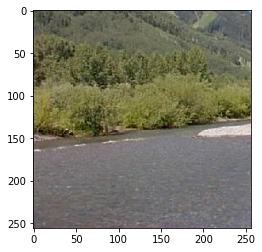

In [ ]:
print(labels[1])

plt.imshow(images[1], cmap='gray')

In [ ]:
generatedFeatures = googlenet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
clf = svm.SVC(kernel = "poly", degree=3, decision_function_shape = "ovo")
clf.fit(TRdata, labels)

SVC(decision_function_shape='ovo', kernel='poly')

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]



In [ ]:
print(Testimages.shape)
print(Testlabels.shape)

(268, 256, 256, 3)
(268,)


In [ ]:
TestgeneratedFeatures = googlenet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted1 = clf.predict(TRdata)

In [ ]:
predicted1

array([1, 4, 7, ..., 6, 1, 2], dtype=int32)

In [ ]:
print(f"{metrics.classification_report(labels, predicted1)}\n")
print(metrics.accuracy_score(labels, predicted1))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       317
           1       0.99      0.97      0.98       325
           2       0.99      0.97      0.98       298
           3       1.00      0.92      0.96       238
           4       1.00      0.92      0.96       271
           5       0.84      1.00      0.91       342
           6       0.98      0.99      0.99       374
           7       1.00      0.89      0.94       255

    accuracy                           0.96      2420
   macro avg       0.97      0.95      0.96      2420
weighted avg       0.96      0.96      0.96      2420


0.9590909090909091


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        39
           1       0.85      0.94      0.89        35
           2       1.00      0.80      0.89        30
           3       0.84      0.95      0.89        22
           4       1.00      0.89      0.94        37
           5       0.97      0.97      0.97        32
           6       0.88      0.81      0.84        36
           7       0.93      1.00      0.96        37

    accuracy                           0.92       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.93      0.92      0.92       268


0.9216417910447762


VGG19

In [ ]:
import tensorflow as tf

vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = vgg.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
clf = svm.SVC(kernel = "poly", degree=4, decision_function_shape = "ovo")
clf.fit(TRdata, labels)

SVC(decision_function_shape='ovo', degree=4, kernel='poly')

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]



In [ ]:
TestgeneratedFeatures = vgg.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       317
           1       0.88      0.95      0.91       325
           2       0.98      0.99      0.99       298
           3       0.99      0.98      0.99       238
           4       1.00      0.99      0.99       271
           5       0.98      0.98      0.98       342
           6       0.94      0.88      0.91       374
           7       1.00      1.00      1.00       255

    accuracy                           0.97      2420
   macro avg       0.97      0.97      0.97      2420
weighted avg       0.97      0.97      0.97      2420


0.965702479338843


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.86      0.91      0.89        35
           2       0.94      0.97      0.95        30
           3       0.95      0.95      0.95        22
           4       0.97      0.97      0.97        37
           5       0.97      0.97      0.97        32
           6       0.91      0.86      0.89        36
           7       0.97      0.95      0.96        37

    accuracy                           0.94       268
   macro avg       0.94      0.94      0.94       268
weighted avg       0.94      0.94      0.94       268


0.9402985074626866


# **Naive Bayes Gaussian**

**Resnet**

In [ ]:
import tensorflow as tf

resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = resnet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(TRdata, labels)

GaussianNB()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = resnet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = gnb.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       374
           7       1.00      1.00      1.00       255

    accuracy                           1.00      2420
   macro avg       1.00      1.00      1.00      2420
weighted avg       1.00      1.00      1.00      2420


0.9995867768595041


test

In [ ]:
predicted = gnb.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.83      0.54      0.66        35
           2       0.60      0.80      0.69        30
           3       1.00      0.36      0.53        22
           4       0.61      0.81      0.70        37
           5       0.85      0.72      0.78        32
           6       0.44      0.61      0.51        36
           7       0.84      0.70      0.76        37

    accuracy                           0.69       268
   macro avg       0.75      0.68      0.69       268
weighted avg       0.74      0.69      0.70       268


0.6940298507462687


**GoogleNet**

In [ ]:
import tensorflow as tf

googlenet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

googlenet.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = googlenet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(TRdata, labels)

GaussianNB()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = googlenet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = gnb.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       317
           1       0.94      0.92      0.93       325
           2       0.91      0.87      0.89       298
           3       0.93      0.89      0.91       238
           4       0.84      0.91      0.87       271
           5       0.87      0.92      0.89       342
           6       0.85      0.80      0.83       374
           7       0.91      0.90      0.90       255

    accuracy                           0.90      2420
   macro avg       0.90      0.90      0.90      2420
weighted avg       0.90      0.90      0.90      2420


0.8962809917355372


test

In [ ]:
predicted = gnb.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        39
           1       1.00      0.66      0.79        35
           2       0.83      0.67      0.74        30
           3       0.77      0.91      0.83        22
           4       0.51      0.97      0.67        37
           5       1.00      0.72      0.84        32
           6       0.79      0.86      0.83        36
           7       0.92      0.59      0.72        37

    accuracy                           0.78       268
   macro avg       0.84      0.78      0.79       268
weighted avg       0.84      0.78      0.79       268


0.7835820895522388


**VGG 19**

In [ ]:
import tensorflow as tf

vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

vgg.summary()

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = vgg.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(TRdata, labels)

GaussianNB()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = vgg.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = gnb.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       317
           1       0.94      1.00      0.97       325
           2       0.99      1.00      0.99       298
           3       0.97      1.00      0.99       238
           4       1.00      0.99      1.00       271
           5       1.00      0.96      0.98       342
           6       0.97      0.92      0.94       374
           7       1.00      1.00      1.00       255

    accuracy                           0.98      2420
   macro avg       0.98      0.98      0.98      2420
weighted avg       0.98      0.98      0.98      2420


0.9809917355371901


test

In [ ]:
predicted = gnb.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.52      0.82      0.63        39
           1       0.71      0.14      0.24        35
           2       0.89      0.53      0.67        30
           3       0.62      0.45      0.53        22
           4       0.47      0.68      0.56        37
           5       0.58      0.88      0.70        32
           6       0.46      0.53      0.49        36
           7       0.87      0.54      0.67        37

    accuracy                           0.58       268
   macro avg       0.64      0.57      0.56       268
weighted avg       0.64      0.58      0.56       268


0.5783582089552238


# **Decision Tree**

**Resnet**

In [ ]:
import tensorflow as tf

resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

resnet.summary()

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = resnet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(TRdata, labels)

DecisionTreeClassifier()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = resnet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       374
           7       1.00      1.00      1.00       255

    accuracy                           1.00      2420
   macro avg       1.00      1.00      1.00      2420
weighted avg       1.00      1.00      1.00      2420


0.9995867768595041


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76        39
           1       0.89      0.94      0.92        35
           2       0.70      0.70      0.70        30
           3       0.63      0.86      0.73        22
           4       0.65      0.65      0.65        37
           5       0.93      0.81      0.87        32
           6       0.69      0.75      0.72        36
           7       0.78      0.68      0.72        37

    accuracy                           0.76       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.76      0.76      0.76       268


0.7574626865671642


**GoogleNet**

In [ ]:
import tensorflow as tf

googlenet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

googlenet.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = googlenet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(TRdata, labels)

DecisionTreeClassifier()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = googlenet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       374
           7       1.00      1.00      1.00       255

    accuracy                           1.00      2420
   macro avg       1.00      1.00      1.00      2420
weighted avg       1.00      1.00      1.00      2420


0.9995867768595041


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.79      0.59      0.68        39
           1       0.61      0.71      0.66        35
           2       0.59      0.43      0.50        30
           3       0.28      0.50      0.35        22
           4       0.43      0.41      0.42        37
           5       0.66      0.72      0.69        32
           6       0.49      0.47      0.48        36
           7       0.58      0.49      0.53        37

    accuracy                           0.54       268
   macro avg       0.55      0.54      0.54       268
weighted avg       0.57      0.54      0.55       268


0.5410447761194029


**VGG 19**

In [ ]:
import tensorflow as tf

vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

vgg.summary()

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = vgg.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(TRdata, labels)

DecisionTreeClassifier()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = vgg.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       374
           7       1.00      1.00      1.00       255

    accuracy                           1.00      2420
   macro avg       1.00      1.00      1.00      2420
weighted avg       1.00      1.00      1.00      2420


0.9995867768595041


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64        39
           1       0.51      0.57      0.54        35
           2       0.63      0.63      0.63        30
           3       0.58      0.82      0.68        22
           4       0.56      0.49      0.52        37
           5       0.53      0.56      0.55        32
           6       0.45      0.53      0.49        36
           7       0.67      0.49      0.56        37

    accuracy                           0.57       268
   macro avg       0.58      0.58      0.58       268
weighted avg       0.58      0.57      0.57       268


0.5708955223880597


**VGG 19 with SVM (But layers with less specific features)**

In [ ]:
import tensorflow as tf
from tensorflow import keras

vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
print(vgg.layers[-2].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='block5_conv4/Relu:0', description="created by layer 'block5_conv4'")


In [ ]:
vgg = keras.Model(inputs=vgg.input,
                           outputs=vgg.layers[-2].output)

vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = vgg.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
clf = svm.SVC(kernel = "poly", degree=4, decision_function_shape = "ovo")

In [ ]:
clf.fit(TRdata, labels)

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]



In [ ]:
TestgeneratedFeatures = vgg.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

**GoogLenet and Naive Bayes (But layers with less specific features)**

In [ ]:
import tensorflow as tf
from tensorflow import keras

googlenet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

googlenet.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 127, 127, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

In [ ]:
print(googlenet.layers[-2].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 192), dtype=tf.float32, name=None), name='activation_281/Relu:0', description="created by layer 'activation_281'")


In [ ]:
googlenet = keras.Model(inputs=googlenet.input,
                           outputs=googlenet.layers[-2].output)

googlenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 127, 127, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = googlenet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(TRdata, labels)

GaussianNB()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = googlenet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = gnb.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       317
           1       0.93      0.91      0.92       325
           2       0.88      0.91      0.89       298
           3       0.94      0.89      0.92       238
           4       0.81      0.89      0.85       271
           5       0.90      0.91      0.90       342
           6       0.85      0.79      0.82       374
           7       0.92      0.91      0.91       255

    accuracy                           0.89      2420
   macro avg       0.89      0.90      0.89      2420
weighted avg       0.89      0.89      0.89      2420


0.8925619834710744


test

In [ ]:
predicted = gnb.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92        39
           1       1.00      0.80      0.89        35
           2       0.96      0.87      0.91        30
           3       0.92      1.00      0.96        22
           4       0.59      0.95      0.73        37
           5       1.00      0.91      0.95        32
           6       0.85      0.97      0.91        36
           7       0.96      0.65      0.77        37

    accuracy                           0.87       268
   macro avg       0.91      0.88      0.88       268
weighted avg       0.90      0.87      0.87       268


0.8694029850746269


**Stage 2**

In [ ]:
import tensorflow as tf
from tensorflow import keras

googlenet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

googlenet.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
print(googlenet.layers[-3].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 768), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")


In [ ]:
googlenet = keras.Model(inputs=googlenet.input,
                           outputs=googlenet.layers[-3].output)

googlenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = googlenet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(TRdata, labels)

GaussianNB()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = googlenet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = gnb.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       317
           1       0.91      0.92      0.91       325
           2       0.85      0.71      0.78       298
           3       0.83      0.87      0.85       238
           4       0.81      0.79      0.80       271
           5       0.80      0.85      0.82       342
           6       0.71      0.73      0.72       374
           7       0.85      0.85      0.85       255

    accuracy                           0.83      2420
   macro avg       0.83      0.83      0.83      2420
weighted avg       0.83      0.83      0.83      2420


0.8264462809917356


test

In [ ]:
predicted = gnb.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85        39
           1       0.91      0.89      0.90        35
           2       0.79      0.63      0.70        30
           3       0.85      1.00      0.92        22
           4       0.76      0.84      0.79        37
           5       0.84      0.81      0.83        32
           6       0.69      0.69      0.69        36
           7       0.90      0.73      0.81        37

    accuracy                           0.81       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.81      0.81      0.81       268


0.8097014925373134


stage 3

In [ ]:
import tensorflow as tf
from tensorflow import keras

googlenet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

googlenet.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 127, 127, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [ ]:
print(googlenet.layers[-6].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 192), dtype=tf.float32, name=None), name='batch_normalization_375/FusedBatchNormV3:0', description="created by layer 'batch_normalization_375'")


In [ ]:
googlenet = keras.Model(inputs=googlenet.input,
                           outputs=googlenet.layers[-6].output)

googlenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 127, 127, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = googlenet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(TRdata, labels)

GaussianNB()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = googlenet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = gnb.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       317
           1       0.92      0.89      0.90       325
           2       0.86      0.91      0.89       298
           3       0.93      0.89      0.91       238
           4       0.81      0.89      0.85       271
           5       0.92      0.92      0.92       342
           6       0.85      0.78      0.81       374
           7       0.91      0.90      0.91       255

    accuracy                           0.89      2420
   macro avg       0.89      0.89      0.89      2420
weighted avg       0.89      0.89      0.89      2420


0.8909090909090909


test

In [ ]:
predicted = gnb.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       1.00      0.79      0.89        39
           1       1.00      0.51      0.68        35
           2       0.91      0.70      0.79        30
           3       0.84      0.95      0.89        22
           4       0.43      0.97      0.60        37
           5       1.00      0.84      0.92        32
           6       0.91      0.86      0.89        36
           7       0.96      0.68      0.79        37

    accuracy                           0.78       268
   macro avg       0.88      0.79      0.81       268
weighted avg       0.88      0.78      0.80       268


0.7835820895522388


stage 4

In [ ]:
import tensorflow as tf
from tensorflow import keras

googlenet = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

googlenet.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 127, 127, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                      

In [ ]:
print(googlenet.layers[-18].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 2048), dtype=tf.float32, name=None), name='average_pooling2d_44/AvgPool:0', description="created by layer 'average_pooling2d_44'")


In [ ]:
googlenet = keras.Model(inputs=googlenet.input,
                           outputs=googlenet.layers[-18].output)

googlenet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 127, 127, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                           

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = googlenet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(TRdata, labels)

GaussianNB()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = googlenet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = gnb.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       317
           1       0.98      0.99      0.99       325
           2       0.99      0.99      0.99       298
           3       1.00      1.00      1.00       238
           4       0.99      0.98      0.99       271
           5       0.98      1.00      0.99       342
           6       0.99      0.97      0.98       374
           7       0.98      1.00      0.99       255

    accuracy                           0.99      2420
   macro avg       0.99      0.99      0.99      2420
weighted avg       0.99      0.99      0.99      2420


0.9884297520661157


test

In [ ]:
predicted = gnb.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        39
           1       0.79      0.66      0.72        35
           2       1.00      0.60      0.75        30
           3       0.85      0.50      0.63        22
           4       0.72      0.84      0.77        37
           5       1.00      0.69      0.81        32
           6       0.36      0.86      0.51        36
           7       0.93      0.38      0.54        37

    accuracy                           0.69       268
   macro avg       0.81      0.67      0.70       268
weighted avg       0.80      0.69      0.70       268


0.6865671641791045


**Resnet with Decision Tree (But layers with less specific features)**

In [ ]:
import tensorflow as tf
from tensorflow import keras

resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

resnet.summary()

94683136/94668760 [==============================] - 4s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
print(resnet.layers[-4].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 2048), dtype=tf.float32, name=None), name='conv5_block3_3_conv/BiasAdd:0', description="created by layer 'conv5_block3_3_conv'")


In [ ]:
resnet = keras.Model(inputs=resnet.input,
                           outputs=resnet.layers[-4].output)

resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = resnet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(TRdata, labels)

DecisionTreeClassifier()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = resnet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       374
           7       1.00      1.00      1.00       255

    accuracy                           1.00      2420
   macro avg       1.00      1.00      1.00      2420
weighted avg       1.00      1.00      1.00      2420


0.9995867768595041


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.33      0.15      0.21        39
           1       0.31      0.11      0.17        35
           2       0.24      0.13      0.17        30
           3       0.00      0.00      0.00        22
           4       0.23      0.41      0.29        37
           5       0.25      0.03      0.06        32
           6       0.14      0.33      0.20        36
           7       0.35      0.62      0.45        37

    accuracy                           0.24       268
   macro avg       0.23      0.22      0.19       268
weighted avg       0.24      0.24      0.21       268


0.24253731343283583


stage 2

In [ ]:
import tensorflow as tf
from tensorflow import keras

resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
print(resnet.layers[-5].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 512), dtype=tf.float32, name=None), name='conv5_block3_2_relu/Relu:0', description="created by layer 'conv5_block3_2_relu'")


In [ ]:
resnet = keras.Model(inputs=resnet.input,
                           outputs=resnet.layers[-5].output)

resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = resnet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(TRdata, labels)

DecisionTreeClassifier()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = resnet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       374
           7       1.00      1.00      1.00       255

    accuracy                           1.00      2420
   macro avg       1.00      1.00      1.00      2420
weighted avg       1.00      1.00      1.00      2420


0.9995867768595041


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60        39
           1       0.57      0.37      0.45        35
           2       0.59      0.63      0.61        30
           3       0.53      0.77      0.63        22
           4       0.65      0.54      0.59        37
           5       0.69      0.62      0.66        32
           6       0.31      0.44      0.37        36
           7       0.61      0.59      0.60        37

    accuracy                           0.56       268
   macro avg       0.57      0.57      0.56       268
weighted avg       0.58      0.56      0.56       268


0.5559701492537313


stage 3

In [ ]:
import tensorflow as tf
from tensorflow import keras

resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=8,
    classifier_activation="softmax",
)

resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
print(resnet.layers[-12].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 2048), dtype=tf.float32, name=None), name='conv5_block3_preact_relu/Relu:0', description="created by layer 'conv5_block3_preact_relu'")


In [ ]:
resnet = keras.Model(inputs=resnet.input,
                           outputs=resnet.layers[-12].output)

resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
images = []
labels = []

for image in normalized_ds:
  images = image[0]
  labels = image[1]

In [ ]:
generatedFeatures = resnet.predict(images)

In [ ]:
generatedFeatures = (generatedFeatures - np.min(generatedFeatures)) / (np.max(generatedFeatures) - np.min(generatedFeatures))
generatedFeatures = np.array(generatedFeatures)

In [ ]:
TRdata = generatedFeatures.reshape((len(generatedFeatures), -1))

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(TRdata, labels)

DecisionTreeClassifier()

In [ ]:
import numpy as np

Testnormalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(Testnormalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
for image in Testnormalized_ds:
  Testimages = image[0]
  Testlabels = image[1]

In [ ]:
TestgeneratedFeatures = resnet.predict(Testimages)

In [ ]:
TestgeneratedFeatures = (TestgeneratedFeatures - np.min(TestgeneratedFeatures)) / (np.max(TestgeneratedFeatures) - np.min(TestgeneratedFeatures))
TestgeneratedFeatures = np.array(TestgeneratedFeatures)

In [ ]:
TSdata = TestgeneratedFeatures.reshape((len(TestgeneratedFeatures), -1))

train

In [ ]:
predicted = clf.predict(TRdata)

In [ ]:
print(f"{metrics.classification_report(labels, predicted)}\n")
print(metrics.accuracy_score(labels, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       298
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       374
           7       1.00      1.00      1.00       255

    accuracy                           1.00      2420
   macro avg       1.00      1.00      1.00      2420
weighted avg       1.00      1.00      1.00      2420


0.9995867768595041


test

In [ ]:
predicted = clf.predict(TSdata)

In [ ]:
print(f"{metrics.classification_report(Testlabels, predicted)}\n")
print(metrics.accuracy_score(Testlabels, predicted))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71        39
           1       0.69      0.63      0.66        35
           2       0.87      0.90      0.89        30
           3       0.43      0.55      0.48        22
           4       0.67      0.59      0.63        37
           5       0.83      0.78      0.81        32
           6       0.51      0.64      0.57        36
           7       0.72      0.62      0.67        37

    accuracy                           0.68       268
   macro avg       0.68      0.68      0.68       268
weighted avg       0.69      0.68      0.68       268


0.6753731343283582
